In [ ]:
import fastf1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
RACE_YEAR = 2023
RACE_GP = "Bahrain"
RACE_TYPE = "R"
import logging
logging.getLogger("fastf1").setLevel(logging.WARNING)
print("Jaivansh Chawla Naive Bayes ML Lab")

Jaivansh Chawla Naive Bayes ML Lab


In [ ]:
session = fastf1.get_session(RACE_YEAR, RACE_GP, RACE_TYPE)
session.load()
laps = session.laps.pick_quicklaps()  # drop in/out laps
weather = session.weather_data
print(f"Loaded {len(laps)} laps for {RACE_YEAR} {RACE_GP}")
print(f"Laps dataset shape (before cleaning): {laps.shape}")

Loaded 826 laps for 2023 Bahrain
Laps dataset shape (before cleaning): (826, 31)


In [ ]:
features = ["LapTime", "Sector1Time", "Sector2Time", "Sector3Time",
            "SpeedI1", "SpeedI2", "SpeedFL", "SpeedST"]
df = laps[["Driver", "LapNumber"] + features].dropna().copy()
# Convert to seconds
for col in ["LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]:
    df[col] = df[col].dt.total_seconds()
# Remove outlier laps (way too slow)
df = df[df["LapTime"] < df["LapTime"].quantile(0.95)]
# Normalize LapTime per driver (relative pace)
df["LapTimeNorm"] = df.groupby("Driver")["LapTime"].transform(
    lambda x: x / x.median()
)
# Add weather (merge nearest by lap number)
df = df.merge(
    weather[["AirTemp", "TrackTemp", "Humidity"]],
    left_index=True, right_index=True, how="left"
).fillna(method="ffill")
# Label: Fast if normalized lap time < 1
df["Class"] = np.where(df["LapTimeNorm"] < 1, "Fast", "Slow")
print(f"✅ Lap dataset ready")
print(f"→ Shape: {df.shape}")
print(f"→ Class distribution: {df['Class'].value_counts().to_dict()}")
df.head()

✅ Lap dataset ready
→ Shape: (476, 15)
→ Class distribution: {'Slow': 244, 'Fast': 232}


C:\Users\Jaivansh Chawla\AppData\Local\Temp\ipykernel_22632\3438294778.py:17: FutureWarning: Laps.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ).fillna(method="ffill")


,Driver,LapNumber,LapTime,Sector1Time,Sector2Time,Sector3Time,SpeedI1,SpeedI2,SpeedFL,SpeedST,LapTimeNorm,AirTemp,TrackTemp,Humidity,Class
1,VER,2.0,97.974,31.342,42.504,24.128,227.0,238.0,278.0,288.0,1.006027,29.7,35.0,19.0,Slow
3,VER,4.0,97.976,31.271,42.642,24.063,228.0,238.0,278.0,289.0,1.006048,29.6,34.9,19.0,Slow
5,VER,6.0,97.986,31.341,42.632,24.013,229.0,239.0,279.0,291.0,1.006151,29.6,34.7,19.0,Slow
6,VER,7.0,98.021,31.290,42.763,23.968,230.0,239.0,279.0,293.0,1.006510,29.6,34.7,19.0,Slow
11,VER,12.0,98.591,31.408,42.951,24.232,231.0,241.0,278.0,294.0,1.012363,29.5,34.1,18.0,Slow


In [ ]:
lap_features = ["Sector1Time", "Sector2Time", "Sector3Time","SpeedI1", "SpeedI2", "SpeedFL", "SpeedST","AirTemp", "TrackTemp", "Humidity"]
X = df[lap_features]
y = df["Class"]
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)
nb = GaussianNB()
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

        Fast       0.75      0.91      0.83        47
        Slow       0.90      0.71      0.80        49

    accuracy                           0.81        96
   macro avg       0.83      0.81      0.81        96
weighted avg       0.83      0.81      0.81        96



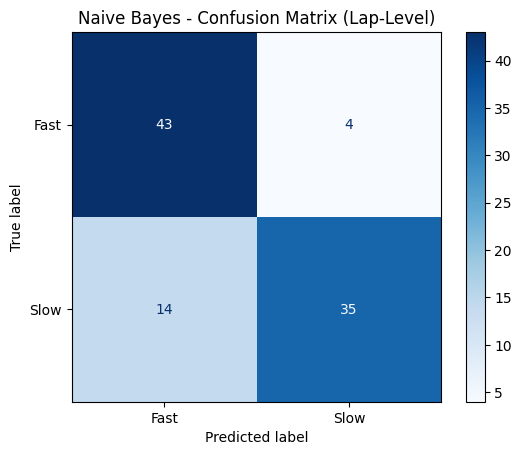

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=nb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Naive Bayes - Confusion Matrix (Lap-Level)")
plt.show()

In [ ]:
results = session.results
driver_summary = df.groupby("Driver").agg({
    "LapTime": ["mean", "min", "std"],
    "LapTimeNorm": "mean",
    "SpeedST": "mean",
    "SpeedFL": "mean"
}).reset_index()
driver_summary.columns = ["Driver", "AvgLap", "BestLap", "LapStd",
                          "NormLap", "AvgST", "AvgFL"]
# Merge with final results
driver_summary = driver_summary.merge(
    results[["Abbreviation", "Position"]],
    left_on="Driver", right_on="Abbreviation", how="left"
).drop(columns="Abbreviation")
# Labels
driver_summary["Winner"] = (driver_summary["Position"] == 1).astype(int)
driver_summary["Top6"] = (driver_summary["Position"] <= 6).astype(int)
print(f"✅ Driver-level dataset ready")
print(f"→ Shape: {driver_summary.shape}")
print(f"→ Drivers: {driver_summary['Driver'].nunique()}")
driver_summary.head()

✅ Driver-level dataset ready
→ Shape: (19, 10)
→ Drivers: 19


,Driver,AvgLap,BestLap,LapStd,NormLap,AvgST,AvgFL,Position,Winner,Top6
0,ALB,98.378667,97.144,0.910528,1.002800,311.888889,286.000000,10.0,0,0
1,ALO,98.003792,96.726,1.005498,1.002519,305.125000,281.458333,3.0,0,1
2,BOT,98.354724,97.379,0.851134,1.005097,291.827586,278.137931,8.0,0,0
3,DEV,98.733500,97.709,0.696057,0.998534,297.875000,280.187500,14.0,0,0
4,GAS,97.467522,95.068,1.170565,0.996998,306.000000,282.782609,9.0,0,0


In [ ]:
X_driver = driver_summary[["AvgLap", "BestLap", "LapStd", "NormLap", "AvgST", "AvgFL"]]
y_driver = driver_summary["Top6"]
scaler_d = StandardScaler()
X_driver_scaled = scaler_d.fit_transform(X_driver)
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(
    X_driver_scaled, y_driver, test_size=0.3, random_state=42, stratify=y_driver
)
nb_driver = GaussianNB()
nb_driver.fit(X_train_d, y_train_d)
y_pred_d = nb_driver.predict(X_test_d)
print(classification_report(y_test_d, y_pred_d))

              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.50      0.50      0.50         2

    accuracy                           0.67         6
   macro avg       0.62      0.62      0.62         6
weighted avg       0.67      0.67      0.67         6



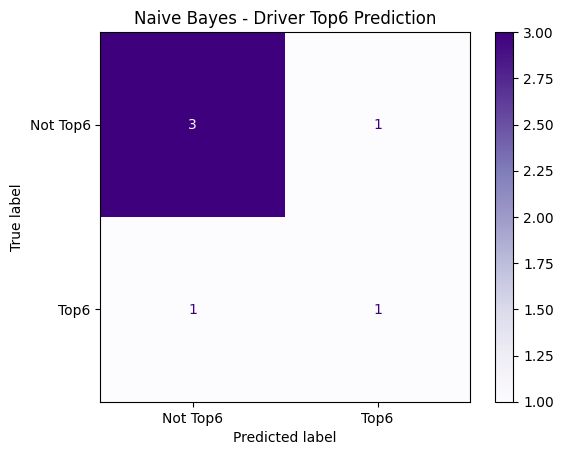

In [ ]:
cm_d = confusion_matrix(y_test_d, y_pred_d)
disp_d = ConfusionMatrixDisplay(confusion_matrix=cm_d, display_labels=["Not Top6", "Top6"])
disp_d.plot(cmap="Purples", values_format="d")
plt.title("Naive Bayes - Driver Top6 Prediction")
plt.show()

In [ ]:
print(f"Lap-level dataset size: {df.shape[0]} samples, {df.shape[1]} features")
print(f"Driver-level dataset size: {driver_summary.shape[0]} samples, {driver_summary.shape[1]} features\n")
queries = [
    ("Fast sector times (90% mean)", (df[lap_features].mean() * 0.9).to_frame().T),
    ("Slow sector times (110% mean)", (df[lap_features].mean() * 1.1).to_frame().T),
]
for q, x in queries:
    x_scaled = scaler.transform(x)
    prob = nb.predict_proba(x_scaled)[0]
    print(f"{q}\n  → Fast={prob[0]:.2f}, Slow={prob[1]:.2f}\n")
max_data = driver_summary[driver_summary["Driver"] == "VER"]
if not max_data.empty:
    print(f"🔍 Checking driver: Max Verstappen (row count: {max_data.shape[0]})")
    x_max = max_data[["AvgLap", "BestLap", "LapStd", "NormLap", "AvgST", "AvgFL"]]
    x_max_scaled = scaler_d.transform(x_max)
    proba_max = nb_driver.predict_proba(x_max_scaled)[0]
    print("Max Verstappen Probabilities:")
    print(f"→ NotTop6={proba_max[0]:.2f}, Top6={proba_max[1]:.2f}")
    # Winner model
    y_winner = driver_summary["Winner"]
    nb_winner = GaussianNB().fit(X_driver_scaled, y_winner)
    win_proba = nb_winner.predict_proba(x_max_scaled)[0]
    print(f"→ Winner Probability={win_proba[1]:.2f}")


Lap-level dataset size: 476 samples, 15 features
Driver-level dataset size: 19 samples, 10 features

Fast sector times (90% mean)
  → Fast=0.00, Slow=1.00

Slow sector times (110% mean)
  → Fast=0.00, Slow=1.00

🔍 Checking driver: Max Verstappen (row count: 1)
Max Verstappen Probabilities:
→ NotTop6=0.00, Top6=1.00
→ Winner Probability=1.00
